In [12]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas_ta as ta
import pandas as pd

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper

In [11]:
mt5.initialize()

True

In [13]:
slippage = 5
days = [17, 20, 21, 22, 23, 24, 27, 28, 29]
data_list = []
for day in days: 
    from_date = datetime(2024, 5, day, tzinfo=pytz.utc)
    to_date = datetime(
        from_date.year, from_date.month, from_date.day, hour=23, tzinfo=pytz.utc
    )
    data_list.append(mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE))

In [14]:
trainrates = pd.DataFrame()
for data in data_list: 
    trainrates = pd.concat([trainrates, Mt5Helper.OHLC(data, "10s")])
trainrates

,open,high,low,close,tick_volume,real_volume
time_msc,,,,,,
2024-05-17 09:00:30+00:00,129350.0,129375.0,129080.0,129235.0,7457,28621
2024-05-17 09:00:40+00:00,129230.0,129280.0,129150.0,129220.0,6750,21242
2024-05-17 09:00:50+00:00,129220.0,129280.0,129220.0,129240.0,3303,8994
2024-05-17 09:01:00+00:00,129245.0,129245.0,129140.0,129170.0,6600,19973
2024-05-17 09:01:10+00:00,129170.0,129200.0,129135.0,129200.0,3533,10667
...,...,...,...,...,...,...
2024-05-29 18:30:40+00:00,NaN,NaN,NaN,NaN,0,0
2024-05-29 18:30:50+00:00,NaN,NaN,NaN,NaN,0,0
2024-05-29 18:31:00+00:00,NaN,NaN,NaN,NaN,0,0


,open,high,low,close,tick_volume,real_volume,sma,current_delta,forecast_delta
open,1.000000,0.999993,0.999992,0.999985,0.062052,0.059896,0.349295,0.009075,0.007649
high,0.999993,1.000000,0.999988,0.999992,0.063737,0.061518,0.348743,0.008863,0.008207
low,0.999992,0.999988,1.000000,0.999992,0.060068,0.057926,0.349899,0.009108,0.008501
close,0.999985,0.999992,0.999992,1.000000,0.061789,0.059594,0.349348,0.008900,0.009008
tick_volume,0.062052,0.063737,0.060068,0.061789,1.000000,0.982658,-0.125601,-0.073738,-0.082421
real_volume,0.059896,0.061518,0.057926,0.059594,0.982658,1.000000,-0.105682,-0.077480,-0.088491
sma,0.349295,0.348743,0.349899,0.349348,-0.125601,-0.105682,1.000000,-0.001303,-0.001766
current_delta,0.009075,0.008863,0.009108,0.008900,-0.073738,-0.077480,-0.001303,1.000000,0.900504
forecast_delta,0.007649,0.008207,0.008501,0.009008,-0.082421,-0.088491,-0.001766,0.900504,1.000000


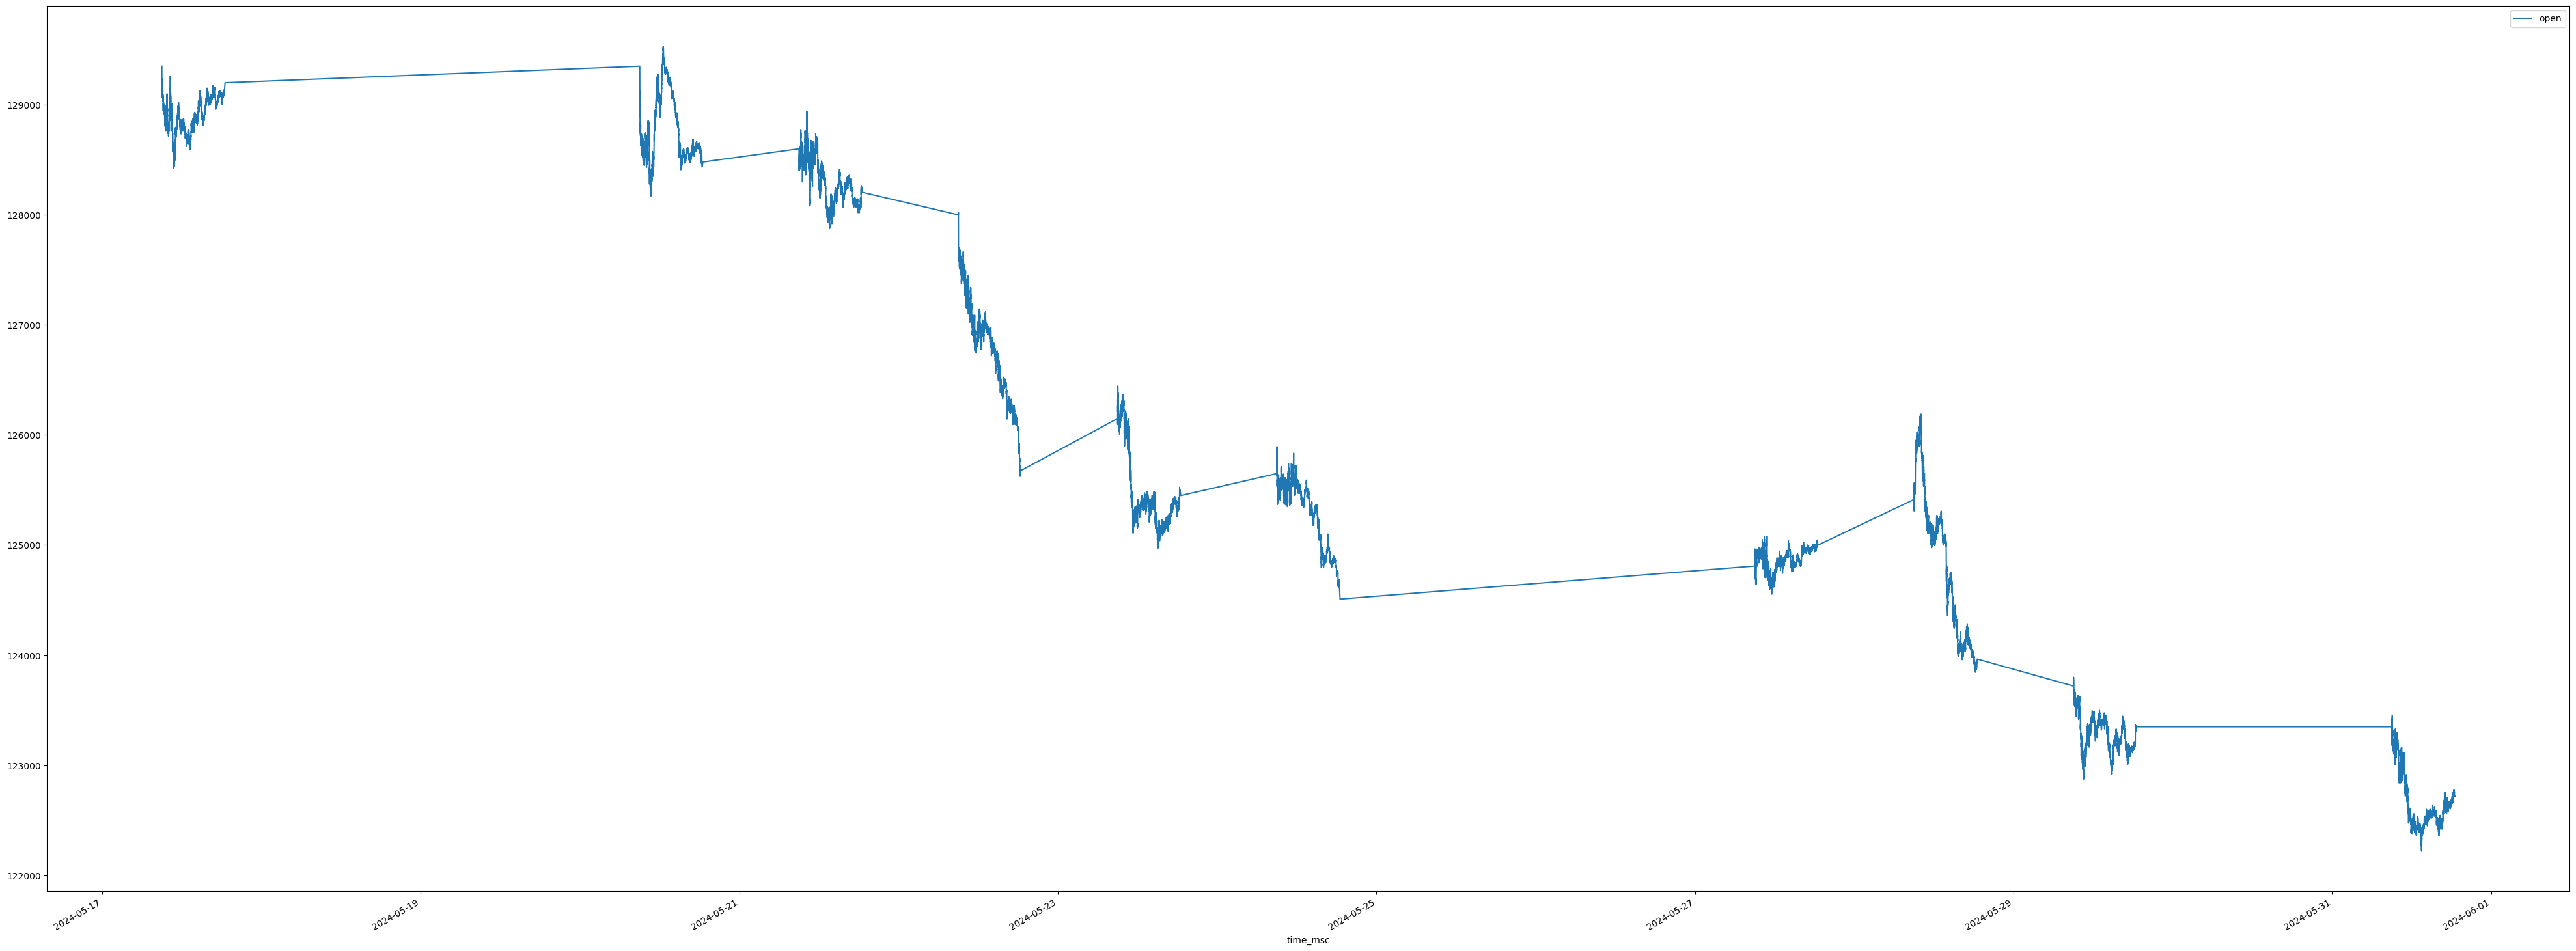

In [47]:
def format_rates(df):
    df.index = df.index.tz_localize(None)

    df["sma"] = df.rolling(14)["open"].mean()
    df["current_delta"] = df["sma"] - df.shift(1)["sma"]
    df["forecast_delta"] = df.shift(-1)["sma"] - df["sma"]

    for c in df.columns:
        df[c] = df[c].apply(lambda it: it if it == it else 0)

    df = df.loc[df["open"] > 0]

    return df


def plot_rates(df, length):
    df.iloc[0:length][
        [
            "open",
        ]
    ].plot(
        subplots=[("open",)],
        figsize=(50, 20),
    )


trainrates = format_rates(trainrates)
plot_rates(trainrates, length=None)

trainrates.corr()

In [48]:
trainrates.to_excel("all_data.xlsx")

In [60]:
from_date = datetime(2024, 6, 3, tzinfo=pytz.utc)
to_date = datetime(
    from_date.year, from_date.month, from_date.day, hour=23, tzinfo=pytz.utc
)
btrates = Mt5Helper.OHLC(mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE), "10s")

btrates = format_rates(btrates)

btrates[["open", "sma", "current_delta", "forecast_delta"]].to_csv("output_vai.csv", sep=";")

In [61]:
y_preds = pd.read_csv(".\output_vai_saida.csv", sep=";")
y_preds.index = pd.to_datetime(y_preds["time_msc"])
y_preds.drop(columns=["time_msc"], inplace=True)
y_preds

,open,sma,current_delta,forecast_delta
time_msc,,,,
2024-06-03 09:00:40,122860.0,0.000000,0.000000,"-2,4999986"
2024-06-03 09:00:50,122905.0,0.000000,0.000000,0
2024-06-03 09:01:00,122700.0,0.000000,0.000000,0
2024-06-03 09:01:10,122710.0,0.000000,0.000000,0
2024-06-03 09:01:20,122755.0,0.000000,0.000000,0
...,...,...,...,...
2024-06-03 18:24:20,122010.0,122041.785714,-5.000000,"-5,002813"
2024-06-03 18:24:30,122015.0,122037.142857,-4.642857,"-4,8240404"
2024-06-03 18:24:40,122015.0,122033.928571,-3.214286,"-3,9303792"


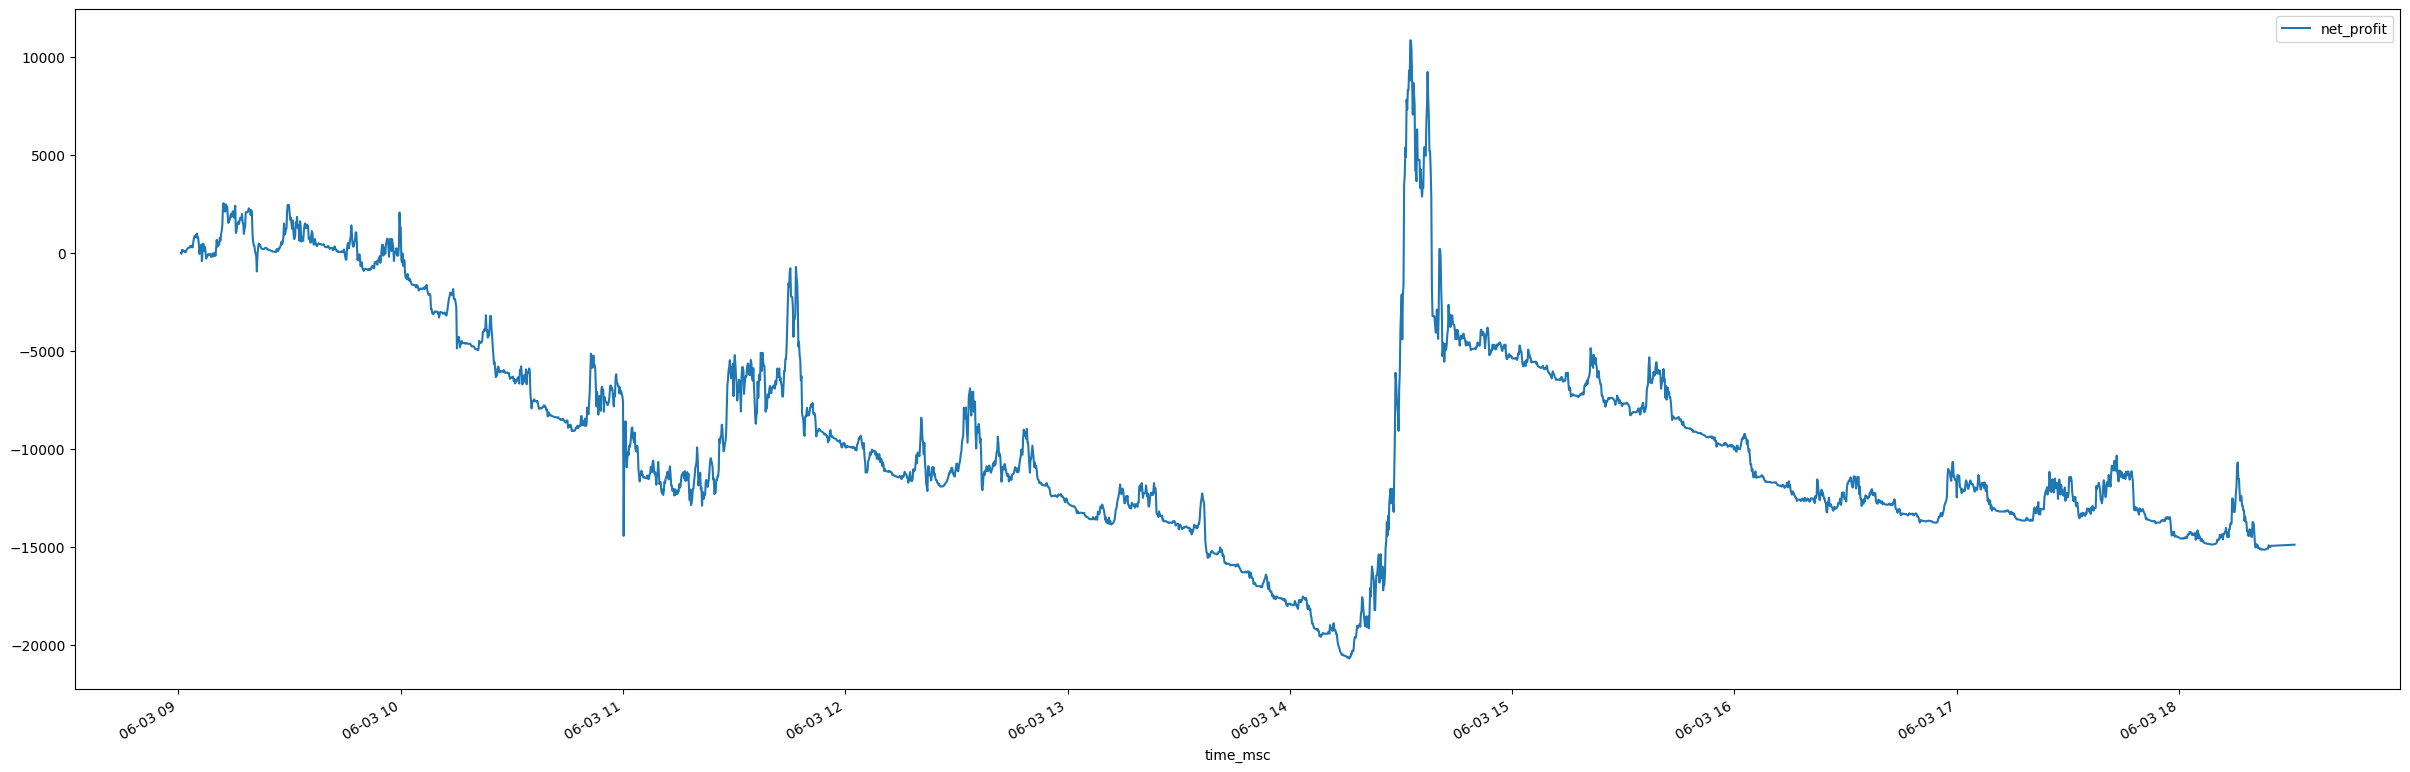

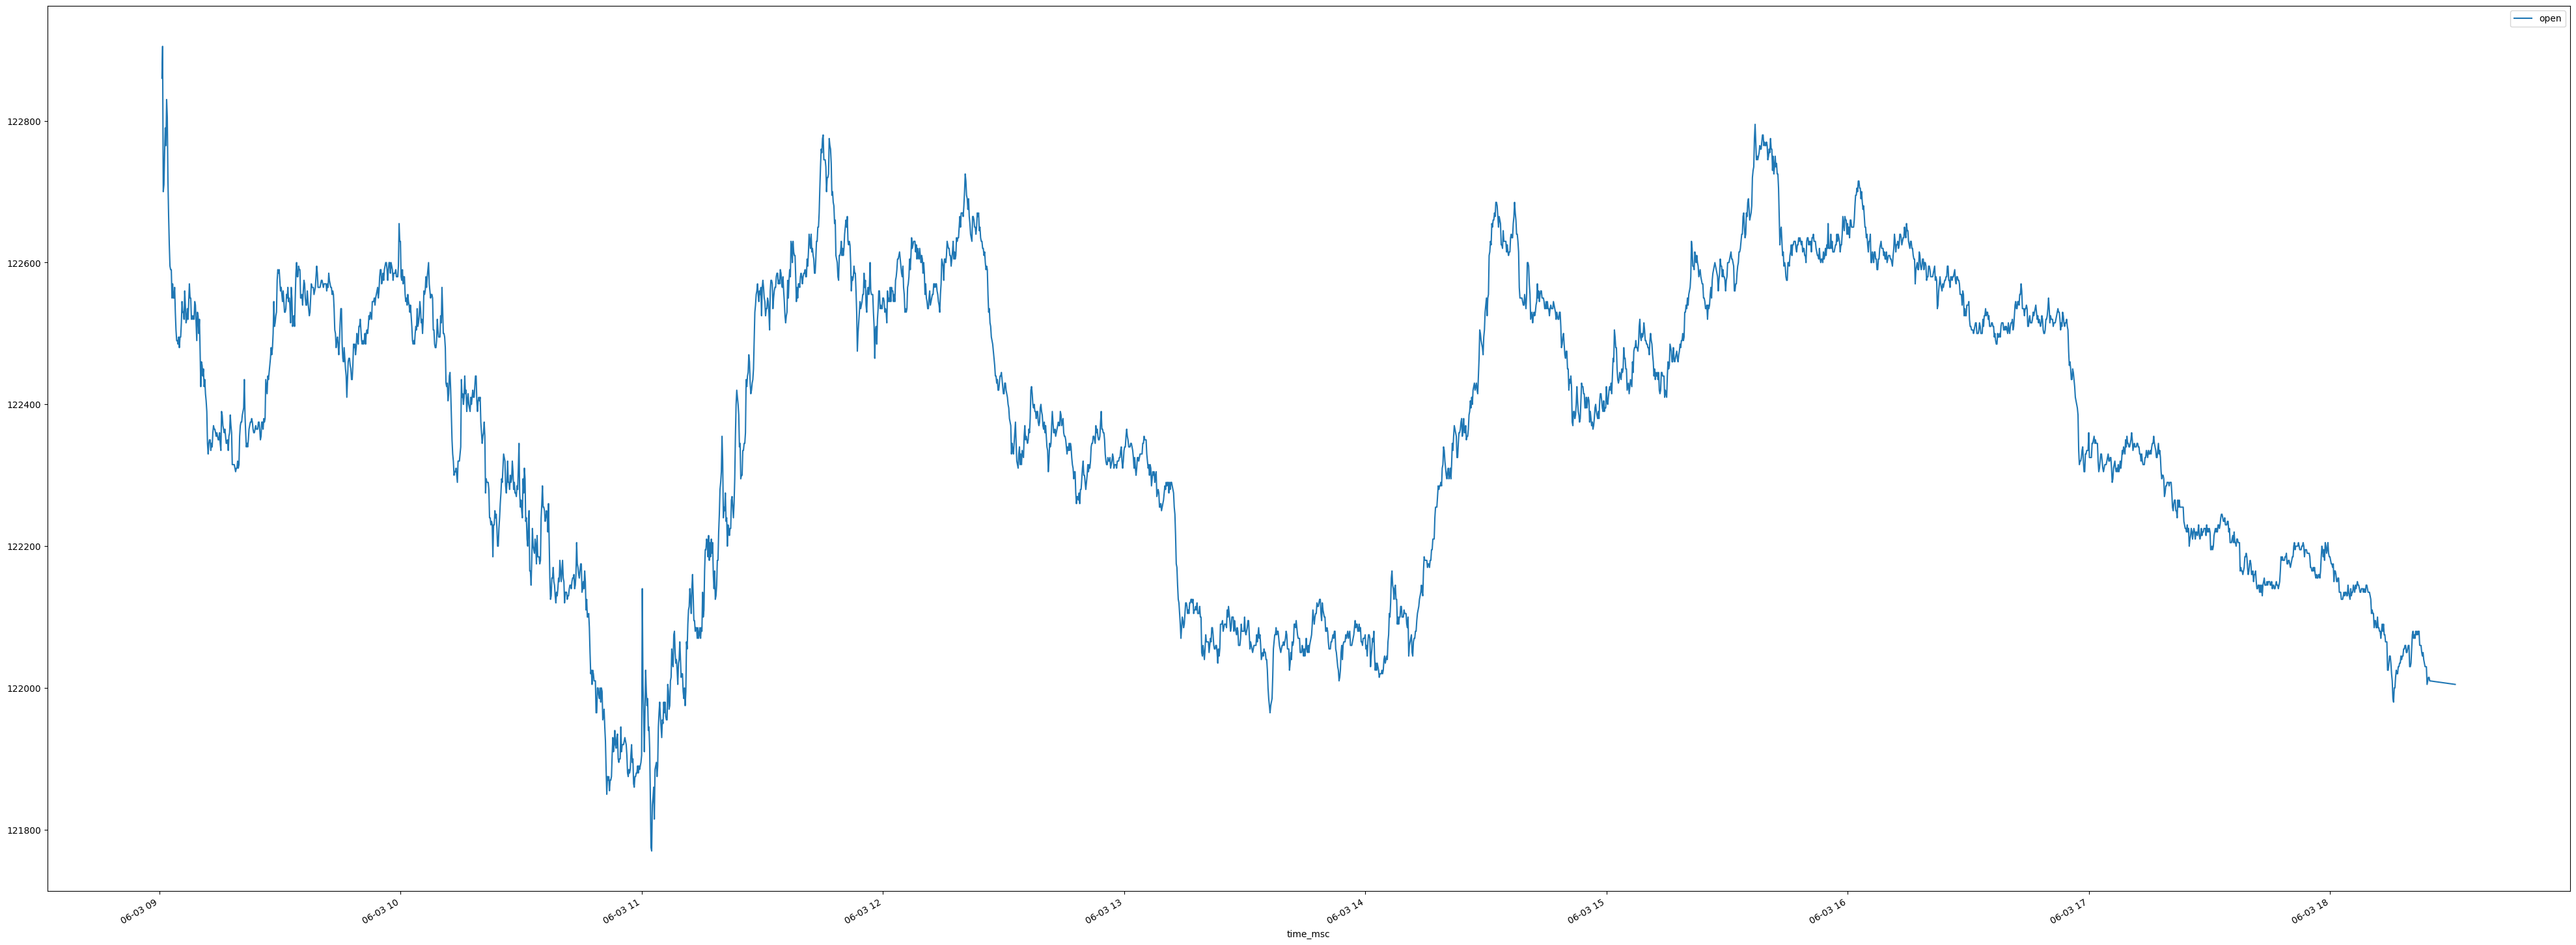

In [63]:
sum_buy = 0
buy_qty = 0
buy_avg = 0
buy_profit = 0

sum_sell = 0
sell_qty = 0
sell_avg = 0
sell_profit = 0

net_qty = 0
net_profit = 0

used_slippage = 0


def update(i):
    btrates.loc[i, "sum_buy"] = sum_buy
    btrates.loc[i, "buy_qty"] = buy_qty
    btrates.loc[i, "buy_avg"] = buy_avg
    btrates.loc[i, "buy_profit"] = buy_profit
    btrates.loc[i, "sum_sell"] = sum_sell
    btrates.loc[i, "sell_qty"] = sell_qty
    btrates.loc[i, "sell_avg"] = sell_avg
    btrates.loc[i, "sell_profit"] = sell_profit
    btrates.loc[i, "net_qty"] = net_qty
    btrates.loc[i, "net_profit"] = net_profit
    btrates.loc[i, "slippage"] = used_slippage


for i, item in btrates.iterrows():
    if np.isnan(item.open):
        update(i)
        continue

    used_slippage = slippage

    y_pred = float(y_preds.loc[i]["forecast_delta"].replace(",", "."))

    if y_pred > 0:
        qty = 1

        if net_qty < -2:
            qty = 2

        sum_buy += qty * (item.open + used_slippage)
        buy_qty += qty

    if y_pred < 0:
        qty = 1

        if net_qty > 2:
            qty = 2

        sum_sell += qty * (item.open - used_slippage)
        sell_qty += qty

    buy_avg = 0 if sum_buy == 0 else sum_buy / buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sell_qty

    buy_profit = 0 if buy_qty == 0 else (item.open - used_slippage - buy_avg) * buy_qty
    sell_profit = (
        0 if sell_qty == 0 else (sell_avg - item.open + used_slippage) * sell_qty
    )

    net_qty = buy_qty - sell_qty
    net_profit = buy_profit + sell_profit

    update(i)


btrates.iloc[:][["net_profit"]].plot(figsize=(30, 10))

plot_rates(btrates, None)

In [43]:
btrates.to_excel("output.xlsx")